# Match regional geodetic mass balance
The OGGM function `match_regional_geodetic_mb()` shifts the mass balance residuals $\beta^*$ to match the observations presented by [Davaze et al. 2020](https://www.frontiersin.org/articles/10.3389/feart.2020.00149/full). Hereafter I'll have a look at it and re-implement it to work with the VAS model

## OGGM flowline model setup

In [1]:
# import internal and externals libraries
import os
import numpy as np
import pandas as pd
import xarray as xr

import logging

log = logging.getLogger('test-notebook')

# import the needed OGGM modules
from oggm import cfg, utils, workflow
from oggm.core import gis, climate, flowline


log.info('Starting run')

# specify glaciers by RGI IDs (INPUT)
rgi_ids = ['RGI60-11.00897']

# compute RGI region and version from RGI IDs
# assuming all RGI IDs are from within one version and region
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:-1]

# load default parameter file
cfg.initialize()

# specify path to working and output directories (INPUT)
WORKING_DIR = '/Users/oberrauch/work/master/working_directories/oggm_run_tmp/'
OUTPUT_DIR = '/Users/oberrauch/work/master/data/oggm_run_tmp/'

# create working directory
utils.mkdir(WORKING_DIR)
utils.mkdir(OUTPUT_DIR)
# set path to working directory
cfg.PATHS['working_dir'] = WORKING_DIR
# set RGI version and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 10

2021-01-22 14:39:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-01-22 14:39:19: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-01-22 14:39:20: oggm.cfg: Multiprocessing: using all available processors (N=4)
2021-01-22 14:39:20: oggm.utils: Checking the download verification file checksum...
2021-01-22 14:39:20: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `6`.
2021-01-22 14:39:20: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


In [2]:
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = True
# set minimum ice thickness to include in glacier length computation
# this reduces weird spikes in length records
cfg.PARAMS['min_ice_thick_for_length'] = 0.1

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True
# operational run, all glaciers should run
cfg.PARAMS['continue_on_error'] = True

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_directories(rgidf, reset=False, force=True)

2021-01-22 14:39:20: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `0.1`.
2021-01-22 14:39:21: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2021-01-22 14:39:21: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


In [3]:
from oggm.core import gcm_climate

In [15]:
tmp = xr.open_dataset(utils.get_demo_file('cesm.TREFHT.160001-200512.selection.nc'))

In [16]:
tmp

<xarray.Dataset>
Dimensions:    (lat: 3, lon: 3, nbnd: 2, time: 4872)
Coordinates:
  * lat        (lat) float64 44.53 46.42 48.32
  * lon        (lon) float64 7.5 10.0 12.5
  * time       (time) object 1600-02-01 00:00:00 ... 2006-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) object ...
Attributes:
    Conventions:               CF-1.0
    source:                    CAM
    case:                      b.e11.BLMTRC5CN.f19_g16.001
    title:                     UNSET
    logname:                   nanr
    host:                      ys0772
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              b.e11.B1850C5CN.f19_g16.0850cntl.001.cam.i.085...
    topography_file:           /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/...
    history:                   Fri Apr  7 14:13:45 2017: ncks -v TREFHT -d lo...
    NCO:                       4.4.4
    nco_openmp_thread_number:  1

In [4]:
# Additional climate file (CESM)
cfg.PATHS['cesm_temp_file'] = utils.get_demo_file('cesm.TREFHT.160001-200512.selection.nc')
cfg.PATHS['cesm_precc_file'] = utils.get_demo_file('cesm.PRECC.160001-200512.selection.nc')
cfg.PATHS['cesm_precl_file'] = utils.get_demo_file('cesm.PRECL.160001-200512.selection.nc')
gcm_climate.process_cesm_data(gdirs[0])

2021-01-22 14:39:23: oggm.core.gcm_climate: (RGI60-11.00897) process_cesm_data
2021-01-22 14:39:25: oggm.core.gcm_climate: (RGI60-11.00897) process_gcm_data
2021-01-22 14:39:25: oggm.core.gcm_climate: FileNotFoundError occurred during task process_gcm_data on RGI60-11.00897: [Errno 2] No such file or directory: b'/Users/oberrauch/work/master/working_directories/oggm_run_tmp/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/climate_historical.nc'


In [5]:

# use default climate (=CRU)
# for HISTALP uncomment the following lines (INPUT)
# cfg.PARAMS['baseline_climate'] = 'HISTALP'
# cfg.PARAMS['prcp_scaling_factor'] = 1.75
# cfg.PARAMS['temp_melt'] = -1.75
# cfg.PARAMS['run_mb_calibration'] = False



# run gis tasks
workflow.gis_prepro_tasks(gdirs)
# run climate tasks
# workflow.execute_entity_task(climate.process_climate_data, gdirs)
# compute local t* and the corresponding mu*
workflow.execute_entity_task(climate.local_t_star, gdirs)


workflow.execute_entity_task(climate.mu_star_calibration, gdirs)
# run inversion tasks
workflow.inversion_tasks(gdirs)
# finalize preprocessing
workflow.execute_entity_task(flowline.init_present_time_glacier, gdirs)

2021-01-22 14:39:25: oggm.workflow: Execute entity task define_glacier_region on 1 glaciers
2021-01-22 14:39:25: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2021-01-22 14:39:26: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2021-01-22 14:39:26: oggm.core.gis: (RGI60-11.00897) glacier_masks
2021-01-22 14:39:26: oggm.core.gis: (RGI60-11.00897) process_dem
2021-01-22 14:39:27: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2021-01-22 14:39:27: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2021-01-22 14:39:27: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2021-01-22 14:39:27: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2021-01-22 14:39:27: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2021-01-22 14:39:27: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2021-01-22 14:39:27: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaci

[None]

Run `match_regional_geodetic_mb()` just to see if it works and what its output is...

In [ ]:
from oggm import workflow
workflow.match_regional_geodetic_mb(gdirs, rgi_region)

## VAS model setup

In [1]:
# import internal and externals libraries
import os
import numpy as np
import pandas as pd
import xarray as xr

import logging

log = logging.getLogger('vas-template')

# import the needed OGGM modules
from oggm import cfg, utils, workflow
from oggm.core import gis, climate, flowline
import oggm_vas as vascaling

log.info('Starting run')

# specify glaciers by RGI IDs (INPUT)
rgi_ids = ['RGI60-11.00897']

# compute RGI region and version from RGI IDs
# assuming all they are all the same
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:-1]

# load default parameter file
vascaling.initialize()

# get environmental variables for working and output directories
WORKING_DIR = '/Users/oberrauch/work/master/working_directories/vas_run/'
OUTPUT_DIR = '/Users/oberrauch/work/master/data/vas_run/'

# create working directory
utils.mkdir(WORKING_DIR)
utils.mkdir(OUTPUT_DIR)
# set path to working directory
cfg.PATHS['working_dir'] = WORKING_DIR
# set RGI version and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 20
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 2.5
cfg.PARAMS['temp_melt'] = -0.5
cfg.PARAMS['run_mb_calibration'] = False
# set minimum ice thickness to include in glacier length computation
# this reduces weird spikes in length records
cfg.PARAMS['min_ice_thick_for_length'] = 0.1

# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = True

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True
# operational run, all glaciers should run
cfg.PARAMS['continue_on_error'] = False

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_directories(rgidf, reset=False, force=True)

# define the local grid and glacier mask
workflow.execute_entity_task(gis.define_glacier_region, gdirs,
                             source=None)
workflow.execute_entity_task(gis.glacier_masks, gdirs)
# process the given climate file
workflow.execute_entity_task(climate.process_climate_data, gdirs)
# compute local t* and the corresponding mu*
workflow.execute_entity_task(vascaling.local_t_star, gdirs)

2021-01-23 14:04:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-01-23 14:04:21: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-01-23 14:04:21: oggm.cfg: Multiprocessing: using all available processors (N=4)
2021-01-23 14:04:22: oggm.utils: Checking the download verification file checksum...
2021-01-23 14:04:23: oggm.cfg: WARNING: adding an unknown parameter `vas_c_area_m2`:`0.191` to PARAMS.
2021-01-23 14:04:23: oggm.cfg: WARNING: adding an unknown parameter `vas_gamma_area`:`1.375` to PARAMS.
2021-01-23 14:04:23: oggm.cfg: WARNING: adding an unknown parameter `vas_c_length_m`:`4.5507` to PARAMS.
2021-01-23 14:04:23: oggm.cfg: WARNING: adding an unknown parameter `vas_q_length`:`2.2` to PARAMS.
2021-01-23 14:04:23: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `6`.
2021-01-23 14:04:23: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2021-01-23 14:04:23: oggm.cfg: PARAMS['temp_melt'] 

[None]

In [4]:
gdir = gdirs[0]

In [6]:
output_filesuffix = init_model_filesuffix = '_test'
vascaling.run_constant_climate(gdir, output_filesuffix=output_filesuffix)

2021-01-23 14:09:00: oggm_vas.core: (RGI60-11.00897) run_constant_climate_test


<class 'oggm_vas.core.VAScalingModel'>: {'rho': 900.0, 'cl': 4.5507, 'ca': 0.191, 'ql': 2.2, 'gamma': 1.375, 'year_0': 0, 'year': 1000, 'area_m2_0': 8036000.0, 'area_m2': 8055191.785826835, 'min_hgt': 2428.1186197289253, 'min_hgt_0': 2430.0, 'max_hgt': 3691.0, 'volume_m3_0': 596297884.1715343, 'volume_m3': 598256886.2516379, 'length_m_0': 4894.636932668758, 'length_m': 4901.939607814831, 'mb_model': <oggm_vas.core.ConstantVASMassBalance object at 0x141118eb8>, 'spec_mb': -4.446613361470818e-05, 'dL': -5.488614902491102e-07, 'dA': -0.0033042332255338223, 'dV': -0.39798137154178037, 'tau_a': 12.541261771912419, 'tau_l': 37.41116742452614}

In [7]:
fp = gdir.get_filepath('model_run', filesuffix=init_model_filesuffix)

In [8]:
fp

'/Users/oberrauch/work/master/working_directories/vas_run/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/model_run_test.nc'

In [3]:
# Get the mass-balance VAS would give out of the box
df = vascaling.compile_fixed_geometry_mass_balance(gdirs, path=False)
df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')

2021-01-21 16:44:19: oggm.workflow: Execute entity task fixed_geometry_mass_balance on 1 glaciers


In [5]:
# And also the Area and calving fluxes
dfs = utils.compile_glacier_statistics(gdirs, path=False)
odf = pd.DataFrame(df.loc[2006:2018].mean(), columns=['SMB'])
odf['AREA'] = dfs.rgi_area_km2 * 1e6

2021-01-21 16:45:06: oggm.workflow: Execute entity task glacier_statistics on 1 glaciers


In [8]:
rgi_reg = '11'

In [9]:
rdf = 'rgi62_areas.csv'
rdf = pd.read_csv(utils.get_demo_file(rdf), dtype={'O1Region': str})
ref_area = rdf.loc[rdf['O1Region'] == rgi_reg].iloc[0]['AreaNoC2NoNominal']
diff = (1 - odf['AREA'].sum() * 1e-6 / ref_area) * 100

In [17]:
rgi_ids = pd.read_csv('/Users/oberrauch/oggm-vas/oggm_vas/data/vas_ref_tstars_rgi6_cru4.csv', index_col=0)
rgi_id.index[[i.startswith('RGI60-13') or i.startswith('RGI60-14') or i.startswith('RGI60-15') for i in rgi_id.index]]

In [29]:
import geopandas as gpd

In [30]:
rgidf = gpd.read_file(utils.get_rgi_region_file(region='14'))

In [31]:
rgidf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
0,RGI60-14.00001,G075911E35764N,20010721,-9999999,75.9105,35.7639,14,2,0.232,5090,...,160,695,0,0,0,0,0,9,None,"POLYGON ((75.91551 35.76513, 75.91550 35.76396..."
1,RGI60-14.00002,G075919E35754N,20010721,-9999999,75.9186,35.7539,14,2,0.025,5178,...,294,283,0,0,0,0,0,9,None,"POLYGON ((75.91968 35.75257, 75.91943 35.75257..."
2,RGI60-14.00003,G075919E35751N,20010721,-9999999,75.9193,35.7507,14,2,0.085,5281,...,297,412,0,0,0,0,0,9,None,"POLYGON ((75.92009 35.75211, 75.92008 35.75202..."
3,RGI60-14.00004,G075128E35772N,20010829,-9999999,75.1278,35.7722,14,2,1.778,4693,...,185,2627,0,0,0,0,0,9,None,"POLYGON ((75.13066 35.78144, 75.13040 35.78144..."
4,RGI60-14.00005,G075593E36006N,20010721,-9999999,75.5932,36.0064,14,2,559.807,3045,...,164,67807,0,0,0,0,2,9,Biafo Glacier,"POLYGON ((75.66395 36.12219, 75.66495 36.12218..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27983,RGI60-14.27984,G078976E33336N,20090907,-9999999,78.9760,33.3360,14,3,0.100,5777,...,331,345,0,0,0,0,9,9,None,"POLYGON ((78.97490 33.33737, 78.97507 33.33740..."
27984,RGI60-14.27985,G079038E33292N,20090907,-9999999,79.0380,33.2920,14,3,0.014,5827,...,33,71,0,0,0,0,9,9,None,"POLYGON ((79.03783 33.29166, 79.03752 33.29165..."
27985,RGI60-14.27986,G079039E33287N,20090907,-9999999,79.0390,33.2870,14,3,0.010,5851,...,351,79,0,0,0,0,9,9,None,"POLYGON ((79.03874 33.28720, 79.03874 33.28740..."
27986,RGI60-14.27987,G079097E33212N,20090907,-9999999,79.0970,33.2120,14,3,0.085,5867,...,8,246,0,0,0,0,9,9,CN5Z422H0060,"POLYGON ((79.09397 33.21189, 79.09399 33.21204..."


In [1]:
# External libs
import numpy as np
import pandas as pd
import datetime
import os
import shutil
import copy
import geopandas as gpd

# import test libs
import unittest
import pytest

# import OGGM modules
import oggm
import oggm.cfg as cfg
from oggm import utils
from oggm.utils import (get_demo_file, ncDataset, md, rmsd_bc, rel_err,
                        corrcoef)
from oggm.core import (gis, climate, centerlines,
                       massbalance, flowline, inversion)
from oggm.tests.funcs import get_test_dir
import oggm_vas as vascaling

# test directory
testdir = os.path.join(get_test_dir(), 'tmp_vas')
if not os.path.exists(testdir):
    os.makedirs(testdir)
    
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file and set working directory
vascaling.initialize()
cfg.PATHS['working_dir'] = testdir
# set path to GIS files
cfg.PARAMS['use_intersects'] = False
cfg.PATHS['dem_file'] = get_demo_file('hef_srtm.tif')
# set parameters for climate file and mass balance calibration
cfg.PARAMS['baseline_climate'] = 'CUSTOM'
cfg.PATHS['climate_file'] = get_demo_file('histalp_merged_hef.nc')
cfg.PARAMS['run_mb_calibration'] = True
# adjust parameters for HistAlp climate
cfg.PARAMS['prcp_scaling_factor'] = 2.5
cfg.PARAMS['temp_melt'] = -0.5
cfg.PARAMS['temp_all_solid'] = 0.

# coveralls.io has issues if multiprocessing is enabled
cfg.PARAMS['use_multiprocessing'] = False

# let's not use the mass balance bias since we want to reproduce
# results from mass balance calibration
cfg.PARAMS['use_bias_for_run'] = False

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI6.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)
# compute mass balance parameters
fn = 'vas_ref_tstars_rgi6_histalp.csv'
fp = vascaling.get_ref_tstars_filepath(fn)
ref_df = pd.read_csv(fp)
vascaling.local_t_star(gdir, ref_df=ref_df)

2021-01-24 11:28:46: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-01-24 11:28:46: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-01-24 11:28:46: oggm.cfg: Multiprocessing: using all available processors (N=4)
2021-01-24 11:28:47: oggm.utils: Checking the download verification file checksum...
2021-01-24 11:28:48: oggm.cfg: WARNING: adding an unknown parameter `vas_c_area_m2`:`0.191` to PARAMS.
2021-01-24 11:28:48: oggm.cfg: WARNING: adding an unknown parameter `vas_gamma_area`:`1.375` to PARAMS.
2021-01-24 11:28:48: oggm.cfg: WARNING: adding an unknown parameter `vas_c_length_m`:`4.5507` to PARAMS.
2021-01-24 11:28:48: oggm.cfg: WARNING: adding an unknown parameter `vas_q_length`:`2.2` to PARAMS.
2021-01-24 11:28:48: oggm.cfg: PARAMS['use_intersects'] changed from `True` to `False`.
2021-01-24 11:28:48: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `CUSTOM`.
2021-01-24 11:28:48: oggm.cfg: PARAMS['run_

In [9]:
vascaling.run_constant_climate(gdir, temperature_bias=0.5, output_filesuffix='_test')

2021-01-24 11:29:52: oggm_vas.core: (RGI60-11.00897) run_constant_climate_test


<class 'oggm_vas.core.VAScalingModel'>: {'rho': 900.0, 'cl': 4.5507, 'ca': 0.191, 'ql': 2.2, 'gamma': 1.375, 'year_0': 0, 'year': 1000, 'area_m2_0': 8036000.0, 'area_m2': 7097759.503205945, 'min_hgt': 2539.355765649882, 'min_hgt_0': 2447.0, 'max_hgt': 3684.0, 'volume_m3_0': 596297884.1715343, 'volume_m3': 502718817.0399172, 'length_m_0': 4894.636932668758, 'length_m': 4529.198014726307, 'mb_model': <oggm_vas.core.ConstantVASMassBalance object at 0x13f39a518>, 'spec_mb': 0.00022986627394153226, 'dL': 7.785783667063516e-06, 'dA': 0.015000463028905035, 'dV': 1.8128172520966122, 'tau_a': 12.384230326168913, 'tau_l': 35.79236179571297}

In [14]:
gcms = pd.read_csv('/Users/oberrauch/work/master/data/all_gcm_list.csv', index_col=0)

In [15]:
gcms

,index,path,folder,fname,valid,gcm,ssp,rea,var
0,0,/home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...,GCM,CESM2-WACCM_ssp126_r1i1p1f1_pr.nc,True,CESM2-WACCM,ssp126,r1i1p1f1,pr
1,2,/home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...,GCM,CESM2-WACCM_ssp585_r1i1p1f1_tas.nc,True,CESM2-WACCM,ssp585,r1i1p1f1,tas
2,7,/home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...,GCM,CESM2-WACCM_ssp370_r1i1p1f1_pr.nc,True,CESM2-WACCM,ssp370,r1i1p1f1,pr
3,8,/home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...,GCM,CESM2-WACCM_ssp370_r1i1p1f1_tas.nc,True,CESM2-WACCM,ssp370,r1i1p1f1,tas
4,9,/home/www/oggm/cmip6/GCM/CESM2-WACCM/CESM2-WAC...,GCM,CESM2-WACCM_ssp585_r1i1p1f1_pr.nc,True,CESM2-WACCM,ssp585,r1i1p1f1,pr
...,...,...,...,...,...,...,...,...,...
121,563,/home/www/oggm/cmip6/additional_GCMs/TaiESM1/T...,additional_GCMs,TaiESM1_ssp585_r1i1p1f1_tas.nc,True,TaiESM1,ssp585,r1i1p1f1,tas
122,565,/home/www/oggm/cmip6/additional_GCMs/CMCC-CM2-...,additional_GCMs,CMCC-CM2-SR5_ssp585_r1i1p1f1_tas.nc,True,CMCC-CM2-SR5,ssp585,r1i1p1f1,tas
123,566,/home/www/oggm/cmip6/additional_GCMs/CMCC-CM2-...,additional_GCMs,CMCC-CM2-SR5_ssp245_r1i1p1f1_tas.nc,True,CMCC-CM2-SR5,ssp245,r1i1p1f1,tas
124,567,/home/www/oggm/cmip6/additional_GCMs/CMCC-CM2-...,additional_GCMs,CMCC-CM2-SR5_ssp585_r1i1p1f1_pr.nc,True,CMCC-CM2-SR5,ssp585,r1i1p1f1,pr


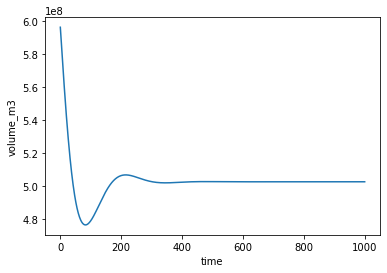

In [10]:
import xarray as xr
fp = gdir.get_filepath('model_diagnostics', filesuffix='_test')
diag_ds = xr.load_dataset(fp)
diag_ds.volume_m3.plot()

In [11]:
# instance a constant mass balance model, centred around t*
mb_model = vascaling.ConstantVASMassBalance(gdir)
# add a positive temperature bias
mb_model.temp_bias = 0.5

# create a VAS model: start with year 0  since we are using a constant
# massbalance model, other values are read from RGI
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
model = vascaling.VAScalingModel(year_0=0, area_m2_0=gdir.rgi_area_m2,
                         min_hgt=min_hgt, max_hgt=max_hgt,
                         mb_model=mb_model)
print(model)

<class 'oggm_vas.core.VAScalingModel'>
year: 0
area [km2]: 8.04
volume [km3]: 0.596
length [km]: 4.89
min elev [m asl.]: 2447
spec mb [mm w.e. yr-1]: -321.31


In [12]:
model.read_from_netcdf(fp)
print(model)

<class 'oggm_vas.core.VAScalingModel'>
year: 1000.0
area [km2]: 7.10
volume [km3]: 0.503
length [km]: 4.53
min elev [m asl.]: 2539
spec mb [mm w.e. yr-1]: 0.00


In [13]:
model.reset_year_0()
print(model)

<class 'oggm_vas.core.VAScalingModel'>
year: 0.0
area [km2]: 7.10
volume [km3]: 0.503
length [km]: 4.53
min elev [m asl.]: 2539
spec mb [mm w.e. yr-1]: 0.00


In [2]:
# run glacier with new mass balance model
ds = model.run_until_and_store(year_end=500, reset=True)

TypeError: run_until_and_store() got an unexpected keyword argument 'output_filesuffix'

In [18]:
float(ds.hydro_year[0].values + (ds.hydro_month[0].values-1)/12)

0.0

In [27]:
float(np.diff(ds.length_m[-2:].values))

0.004301224702430773

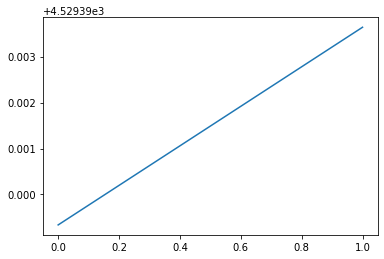

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ds.length_m[-2:].values)

In [26]:
np.diff([10,13])

array([3])

In [2]:
# Get the mass-balance OGGM would give out of the box
df = utils.compile_fixed_geometry_mass_balance(gdirs, path=False)
df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')

2021-01-21 16:02:06: oggm.workflow: Execute entity task fixed_geometry_mass_balance on 1 glaciers


FileNotFoundError: [Errno 2] No such file or directory: '/Users/oberrauch/work/master/working_directories/vas_run/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/inversion_flowlines.pkl'

In [ ]:
def fixed_geometry_mass_balance(gdir, ys=None, ye=None, years=None,
                                monthly_step=False,
                                use_inversion_flowlines=True,
                                climate_filename='climate_historical',
                                climate_input_filesuffix=''):
    """Computes the mass-balance with climate input from e.g. CRU or a GCM.

    Parameters
    ----------
    gdir : :py:class:`oggm.GlacierDirectory`
        the glacier directory to process
    ys : int
        start year of the model run (default: from the climate file)
        date)
    ye : int
        end year of the model run (default: from the climate file)
    years : array of ints
        override ys and ye with the years of your choice
    monthly_step : bool
        whether to store the diagnostic data at a monthly time step or not
        (default is yearly)
    use_inversion_flowlines : bool
        whether to use the inversion flowlines or the model flowlines
    climate_filename : str
        name of the climate file, e.g. 'climate_historical' (default) or
        'gcm_data'
    climate_input_filesuffix: str
        filesuffix for the input climate file
    """

    if monthly_step:
        raise NotImplementedError('monthly_step not implemented yet')

    mb = MultipleFlowlineMassBalance(gdir, mb_model_class=PastMassBalance,
                                     filename=climate_filename,
                                     use_inversion_flowlines=use_inversion_flowlines,
                                     input_filesuffix=climate_input_filesuffix)

    if years is None:
        if ys is None:
            ys = mb.flowline_mb_models[0].ys
        if ye is None:
            ye = mb.flowline_mb_models[0].ye
        years = np.arange(ys, ye + 1)

    odf = pd.Series(data=mb.get_specific_mb(year=years),
                    index=years)
    return odf

In [ ]:
def match_regional_geodetic_mb(gdirs, rgi_reg):
    """Regional shift of the mass-balance residual to match observations.

    This is useful for operational runs, but also quite hacky.
    Let's hope we won't need this for too long.

    Parameters
    ----------
    gdirs : the list of gdirs (ideally the entire region_
    rgi_reg : str
       the rgi region to match
    """

    # Get the mass-balance OGGM would give out of the box
    df = utils.compile_fixed_geometry_mass_balance(gdirs, path=False)
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')

    # And also the Area and calving fluxes
    dfs = utils.compile_glacier_statistics(gdirs, path=False)
    odf = pd.DataFrame(df.loc[2006:2018].mean(), columns=['SMB'])
    odf['AREA'] = dfs.rgi_area_km2 * 1e6
    # Just take the calving rate and change its units
    # Original units: km3 a-1, to change to mm a-1 (units of specific MB)
    rho = cfg.PARAMS['ice_density']
    if 'calving_flux' in dfs:
        odf['CALVING'] = dfs['calving_flux'].fillna(0) * 1e9 * rho / odf['AREA']
    else:
        odf['CALVING'] = 0

    # We have to drop nans here, which occur when calving glaciers fail to run
    odf = odf.dropna()

    # Compare area with total RGI area
    rdf = 'rgi62_areas.csv'
    rdf = pd.read_csv(utils.get_demo_file(rdf), dtype={'O1Region': str})
    ref_area = rdf.loc[rdf['O1Region'] == rgi_reg].iloc[0]['AreaNoC2NoNominal']
    diff = (1 - odf['AREA'].sum() * 1e-6 / ref_area) * 100
    msg = 'Applying geodetic MB correction on RGI reg {}. Diff area: {:.2f}%'
    log.workflow(msg.format(rgi_reg, diff))

    # Total MB OGGM
    out_smb = np.average(odf['SMB'], weights=odf['AREA'])  # for logging
    out_cal = np.average(odf['CALVING'], weights=odf['AREA'])  # for logging
    smb_oggm = np.average(odf['SMB'] - odf['CALVING'], weights=odf['AREA'])

    # Total MB Reference
    df = 'table_hugonnet_regions_10yr_20yr_ar6period.csv'
    df = pd.read_csv(utils.get_demo_file(df))
    df = df.loc[df.period == '2006-01-01_2019-01-01'].set_index('reg')
    smb_ref = df.loc[int(rgi_reg), 'dmdtda']

    # Diff between the two
    residual = smb_ref - smb_oggm

    # Let's just shift
    log.workflow('Shifting regional MB bias by {}'.format(residual))
    log.workflow('Observations give {}'.format(smb_ref))
    log.workflow('OGGM SMB gives {}'.format(out_smb))
    log.workflow('OGGM frontal ablation gives {}'.format(out_cal))
    for gdir in gdirs:
        try:
            df = gdir.read_json('local_mustar')
            gdir.add_to_diagnostics('mb_bias_before_geodetic_corr', df['bias'])
            df['bias'] = df['bias'] - residual
            gdir.write_json(df, 'local_mustar')
        except FileNotFoundError:
            pass

## 1. Preprocess a subset of an RGI region
This example shows how to run the first steps of the OGGM preprocessing chain for a subset of the Alps - the Rofental catchment in the Austrian Alps (see [docs.oggm.org](http://docs.oggm.org/en/latest/run_examples/run_rgi_region.html)).

In [ ]:
# Python imports
import os

# Libs
import geopandas as gpd
import shapely.geometry as shpg

# Locals
from oggm import cfg, utils, workflow

In [ ]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '62'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)
wdir = utils.gettempdir('match_regional_mb')
utils.mkdir(wdir, reset=True)
cfg.PATHS['working_dir'] = wdir

In [ ]:
wdir

In [ ]:
# use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

In [ ]:
# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

In [ ]:
# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(cfg.PATHS['working_dir'], 'rgi_rofental.shp'))

In [ ]:
# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

print('Starting OGGM run')
print('Number of glaciers: {}'.format(len(rgidf)))

# Go - initialize glacier directories
gdirs_list = workflow.init_glacier_regions(rgidf)

In [ ]:
# select a number of glaciers
gdirs = gdirs_list.copy()  # selecting all

In [ ]:
from oggm.core import vascaling, climate
# use default climate (=CRU), for HISTALP uncomment the following lines
# cfg.PARAMS['baseline_climate'] = 'HISTALP'
# cfg.PARAMS['prcp_scaling_factor'] = 1.75
# cfg.PARAMS['temp_melt'] = -1.75

# run all GIS tasks
workflow.gis_prepro_tasks(gdirs)

In [ ]:
# execute climate tasks
workflow.execute_entity_task(climate.process_climate_data, gdirs);
workflow.execute_entity_task(vascaling.local_t_star, gdirs);

In [ ]:
# Compile output
utils.compile_glacier_statistics(gdirs)
utils.write_centerlines_to_shape(gdirs)

In [ ]:
# Imports
from os import path
import geopandas as gpd
import matplotlib.pyplot as plt
from oggm.utils import get_demo_file, gettempdir

# Local working directory (where OGGM wrote its output)
WORKING_DIR = cfg.PATHS['working_dir']

# Plot: the basin, the outlines and the centerlines
basin = gpd.read_file(get_demo_file('rofental_hydrosheds.shp'))
rgi = gpd.read_file(path.join(WORKING_DIR, 'rgi_rofental.shp'))
centerlines = gpd.read_file(path.join(WORKING_DIR, 'glacier_centerlines.shp'))

f, ax = plt.subplots()
basin.plot(ax=ax, color='k', alpha=0.2)
rgi.plot(ax=ax, color='C0')
centerlines.plot(ax=ax, color='C3')
plt.title('Rofental glaciers and centerlines')
plt.tight_layout()
plt.show()

## 2. Complete run for a list of glaciers
This example shows how to run the OGGM model for a list of selected glaciers.

Note that the default in OGGM is to use a previously calibrated list of $t^*$ for the run, which means that we don't have to calibrate the mass balance model ourselves (thankfully, otherwise you'd have to add all the calibration glaciers to your list too).

Note that in order to be correct, the automated calibration can only be used if the model parameters don't change between the calibration and the run. After testing, it appears that changing the `border` parameter won't affect the results much (as expected). So it's ok to change this parameters. Some other parameters (e.g. topo smoothing, dx, precipitation factor, alternative climate data, ...) will probaly need a re-calibration step (see [3. Run the mass balance calibration](http://docs.oggm.org/en/latest/run_examples/run_mb_calibration.html)).


In [ ]:
import importlib
importlib.reload(vascaling)
importlib.reload(workflow)

In [ ]:
# Random climate representative for the tstar climate, without bias
# In an ideal world this would imply that the glaciers remain stable,
# but it doesn't have to be so
nyears=200
workflow.execute_entity_task(vascaling.run_random_climate, gdirs,
                             nyears=nyears, bias=0, seed=12);

In [ ]:
import numpy as np
import pandas as pd
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:
    path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

In [ ]:
path

In [ ]:
volume_m3.sum(axis=1).plot()

## Test some stuff

In [ ]:
# Python imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as shpg

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow
from oggm.core import vascaling, climate

In [ ]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '61'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)

wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'
utils.mkdir(wdir)
cfg.PATHS['working_dir'] = wdir

# We use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(wdir, 'rgi_rofental.shp'))

# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# Go - initialize glacier directories
gdirs = workflow.init_glacier_regions(rgidf)

In [ ]:
# select Hintereisferener
gdir = gdirs[0]
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
vascaling.run_random_vas_climate(gdir, y0=2000)

In [ ]:
path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
df = pd.read_csv(path, index_col=0)
df.head()

In [ ]:
df.volume_m3.plot()

### Access `model_diagnostice` from already run gdirs

In [ ]:
# Python imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as shpg

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow
from oggm.core import vascaling, climate

In [ ]:
# Initialize OGGM and set up the default run parameters
cfg.initialize()
rgi_version = '61'
rgi_region = '11'  # Alps

# Local working directory (where OGGM will write its output)

wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'
utils.mkdir(wdir)
cfg.PATHS['working_dir'] = wdir

# We use intersects
path = utils.get_rgi_intersects_region_file(rgi_region, version=rgi_version)
cfg.set_intersects_db(path)

# RGI file
path = utils.get_rgi_region_file(rgi_region, version=rgi_version)
rgidf = gpd.read_file(path)

# Get the Rofental Basin file
path = utils.get_demo_file('rofental_hydrosheds.shp')
basin = gpd.read_file(path)

# Take all glaciers in the Rofental Basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(rgidf.CenLon, rgidf.CenLat)]
rgidf = rgidf.loc[in_bas]
# Store them for later
rgidf.to_file(os.path.join(wdir, 'rgi_rofental.shp'))

# Sort for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# Go - initialize glacier directories
gdirs = workflow.init_glacier_regions(rgidf)

In [ ]:
nyears = 300
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:
    path = gdir.get_filepath('model_diagnostics', filesuffix='vas')
    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

In [ ]:
volume_m3.sum(axis=1).plot()

In [ ]:
# Imports
import os
import xarray as xr
import matplotlib.pyplot as plt
from oggm.utils import get_demo_file, gettempdir

# Local working directory (where OGGM wrote its output)
wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'
# Read the files using xarray
ds = xr.open_dataset(os.path.join(wdir, 'run_output_commitment.nc'))

In [ ]:
# Volume
(ds.volume.sum(dim='rgi_id')).plot(label='OGGM')
volume_m3.sum(axis=1).plot(label='VAS')
plt.legend()
plt.title('Overall glacier volume - Rofental')
plt.xlabel('')
plt.ylabel('Volume [m$^3$]')

In [ ]:
# Local working directory (where OGGM will write its output)
wdir = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'
utils.mkdir(wdir, reset=False)
cfg.PATHS['working_dir'] = wdir
gdirs = workflow.init_glacier_regions()

In [ ]:
from oggm.core import flowline
flowline.init_present_time_glacier(gdirs[1])

In [ ]:
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
flowline.run_random_climate(gdirs[1], nyears=300, y0=1999, seed=2,
                            output_filesuffix='_commitment')

In [ ]:
path = gdirs[1].get_filepath('model_diagnostics', filesuffix='_commitment')
path

In [ ]:
nyears = 300
# create empty container
volume_m3 = pd.DataFrame(index=np.arange(0,nyears))
# iterate over all gdirs
for gdir in gdirs:

    df = pd.read_csv(path, index_col=0)
    vol = df.volume_m3
    rgi_id = gdir.rgi_id
    volume_m3[rgi_id] = vol

In [ ]:
path

In [ ]:
import xarray as xa
ds = xa.open_dataset(path)
ds.volume_m3.plot()

### Quick test of RandomClimate

In [ ]:
# quick-test of the RandomVASMassBalanceModel
import importlib
importlib.reload(vascaling)

In [ ]:
import numpy as np

In [ ]:
# select Hintereisferner gdir
gdir = gdirs[int(np.where([gdir.name == 'Hintereisferner' for gdir in gdirs])[0])]
gdir

In [ ]:
rand_mbmod = vascaling.RandomVASMassBalance(gdir=gdir, seed=12, y0=1999)

In [ ]:
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
year = 2043
r_yr = rand_mbmod.get_state_yr(year)
mb = rand_mbmod.get_specific_mb(min_hgt, max_hgt, year)
print('Year {} correpsonds to mb year {}, resulting in {} mm w.e. yr-1'.format(year, r_yr, mb))

In [ ]:
years = np.arange(2018, 2200)
mb = np.empty(years.size)
r_yrs = np.empty(years.size)
for i, year in enumerate(years):
    mb[i] = rand_mbmod.get_specific_mb(min_hgt, max_hgt, year)
    r_yrs[i] = rand_mbmod.get_state_yr(year)

import pandas as pd
df = pd.DataFrame({'mb':mb, 'r_yr':r_yrs}, index=years)

In [ ]:
df.mb.plot()

In [ ]:
local_tstar = gdir.read_json('vascaling_mustar')
t_star = local_tstar['t_star']

In [ ]:
import matplotlib.pyplot as plt
df.r_yr.plot()
plt.axhline(t_star-15)
plt.axhline(t_star+15)

In [ ]:
ls /Users/oberrauch/master/working_sirectories/commitment_run_vas/per_glacier/RGI60-11/RGI60-11.00/

### Store to xarray

In [ ]:
path = '/Users/oberrauch/master/working_sirectories/commitment_run_oggm/'+\
    'per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00731/model_run_commitment.nc'
import xarray as xr
xr.open_dataarray(path)

In [ ]:
path = '/Users/oberrauch/master/working_sirectories/commitment_run_vas/'+\
    'per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00739/model_diagnosticsvas.nc'
df = pd.read_csv(path, index_col=0)
df.head()

In [ ]:
from time import gmtime, strftime
import xarray as xr

In [ ]:
diag_ds = xr.Dataset()

# Global attributes
diag_ds.attrs['description'] = 'OGGM model output'
# diag_ds.attrs['oggm_version'] = __version__
diag_ds.attrs['calendar'] = '365-day no leap'
diag_ds.attrs['creation_date'] = strftime("%Y-%m-%d %H:%M:%S",
                                          gmtime())


diag_ds

In [ ]:
# Coordinates
diag_ds.coords['time'] = ('time', monthly_time)
diag_ds.coords['hydro_year'] = ('time', yrs)
diag_ds.coords['hydro_month'] = ('time', months)
diag_ds.coords['calendar_year'] = ('time', cyrs)
diag_ds.coords['calendar_month'] = ('time', cmonths)

In [ ]:
utils.monthly_timeseries(20, 10)

In [ ]:
# time
        yearly_time = np.arange(np.floor(self.yr), np.floor(y1)+1)

        if store_monthly_step:
            monthly_time = utils.monthly_timeseries(self.yr, y1)
        else:
            monthly_time = np.arange(np.floor(self.yr), np.floor(y1)+1)
        yrs, months = utils.floatyear_to_date(monthly_time)
        cyrs, cmonths = utils.hydrodate_to_calendardate(yrs, months)